# Requirement 3 - Sentiment Analysis

In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from timeit import default_timer as timer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import LinearSVC
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)
%matplotlib inline

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/dimitriosrou/anaconda3/envs/ml_gpu/lib/python3.6/site-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [5]:
np.random.seed(42)
tf.random.set_seed(22)

In [6]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
df = pd.read_csv('train.csv')

In [8]:
df.head()

,Content,Label,Id
0,Whoever made this movie must have done it as a...,0,0
1,I love this movie because I grew up around har...,1,1
2,"I had some expectation for the movie, since it...",0,2
3,"During the early 1980's, Kurt Thomas was somet...",0,3
4,Poor Will would be rolling over in his grave i...,0,4


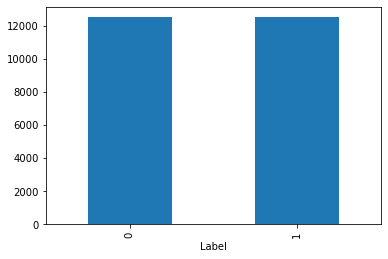

In [9]:
fig = plt.figure()
df.groupby('Label')['Content'].count().plot.bar()
plt.show()

In [10]:
df.groupby('Label')['Content'].count() / len(df)

Label
0    0.5
1    0.5
Name: Content, dtype: float64

In [11]:
def get_metrics(y_true, y_pred, metrics):
    metrics[0] += accuracy_score(y_true, y_pred)
    metrics[1] += precision_score(y_true, y_pred, average='macro')
    metrics[2] += recall_score(y_true, y_pred, average='macro')
    metrics[3] += f1_score(y_true, y_pred, average='macro')
    return metrics

In [12]:
def evaluate_classifier(clf, kfold, X, y, vectorizer, svd_enable=False):
    metrics = np.zeros(4)
    if svd_enable:
        svd = TruncatedSVD(n_components=300)
    start = timer()
    for train, cv in kfold.split(X, y):
        X_train, X_cv = X[train], X[cv]
        y_train, y_cv = y[train], y[cv]
        X_train_gen = [x for x in X_train]
        vectorizer.fit(X_train_gen)
        X_train_vec = vectorizer.transform(X_train_gen)
        if svd_enable:
            svd.fit(X_train_vec, y_train)
            X_train_vec = svd.transform(X_train_vec)
        clf.fit(X_train_vec, y_train)
        X_cv_gen = [x for x in X_cv]
        X_cv_vec = vectorizer.transform(X_cv_gen)
        if svd_enable:
            X_cv_vec = svd.transform(X_cv_vec)
        y_pred = clf.predict(X_cv_vec)
        metrics = get_metrics(y_cv, y_pred, metrics)
    dt = timer() - start
    metrics = metrics * 100 / 5
    print('Evaluation of classifier finished in {:.2f} s \n'
          'Average accuracy: {:.2f} % \n'
          'Average precision: {:.2f} % \n'
          'Average recall: {:.2f} % \n'
          'Average f-measure: {:.2f} % \n'
          .format(dt, metrics[0], metrics[1],
                  metrics[2], metrics[3]))

## Machine Learning & BoW

In [13]:
# 5-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=56)

# Hashing vectorizer and stop words
stop_words = ENGLISH_STOP_WORDS
hashing = HashingVectorizer(stop_words=stop_words)
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=3, 
                        max_df=0.5, ngram_range=(1, 2))
# SVM and Random Forest
svm = LinearSVC()

# SVD
svd = TruncatedSVD(n_components=250)

In [ ]:
X = df['Content'].to_dense().values
y = df['Label'].to_dense().values

In [ ]:
# SVM - BoW
evaluate_classifier(svm, kf, X, y, tfidf)

## Deep Learning with Keras

In [ ]:
for train, cv in kf.split(X, y):
    X_train, X_cv = X[train], X[cv]
    y_train, y_cv = y[train], y[cv]
    X_train_gen = [x for x in X_train]
    X_cv_gen = [x for x in X_cv]

In [14]:
X = df['Content'].values
y = df['Label'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

In [41]:
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=3, 
                        max_df=0.5, ngram_range=(1, 2))
#X_train_gen = [x for x in X_train]
tfidf.fit(X_train)
X_train_vec = tfidf.transform(X_train)

In [42]:
input_shape = X_train_vec.shape[1:]

In [43]:
X_train_vec.shape

(21250, 135666)

In [48]:
keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Dropout(0.25, input_shape=input_shape),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.9),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.85),
#     keras.layers.Embedding(input_dim=35000, output_dim=64),
#     keras.layers.LSTM(32),
    keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   "imdb_sentiment.h5", save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.7, patience=3)
optimizer = keras.optimizers.Adam(lr=1e-2, amsgrad=True)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [49]:
history = model.fit(X_train_vec, y_train,
                    batch_size=256, epochs=80, 
                    callbacks=[early_stopping, 
                               model_checkpoint,
                               reduce_lr],
                    validation_split=0.15)

Train on 18062 samples, validate on 3188 samples
Epoch 1/80
18062/18062 [==============================] - 17s 958us/sample - loss: 0.6437 - accuracy: 0.6018 - val_loss: 0.4416 - val_accuracy: 0.8695
Epoch 2/80
18062/18062 [==============================] - 14s 754us/sample - loss: 0.4941 - accuracy: 0.7597 - val_loss: 0.3343 - val_accuracy: 0.8849
Epoch 3/80
18062/18062 [==============================] - 14s 753us/sample - loss: 0.4276 - accuracy: 0.7959 - val_loss: 0.3146 - val_accuracy: 0.8905
Epoch 4/80
18062/18062 [==============================] - 14s 754us/sample - loss: 0.3886 - accuracy: 0.8241 - val_loss: 0.2791 - val_accuracy: 0.8965
Epoch 5/80
18062/18062 [==============================] - 14s 752us/sample - loss: 0.3504 - accuracy: 0.8451 - val_loss: 0.2733 - val_accuracy: 0.8996
Epoch 6/80
18062/18062 [==============================] - 14s 753us/sample - loss: 0.3312 - accuracy: 0.8539 - val_loss: 0.2596 - val_accuracy: 0.8962
Epoch 7/80
18062/18062 [=====================

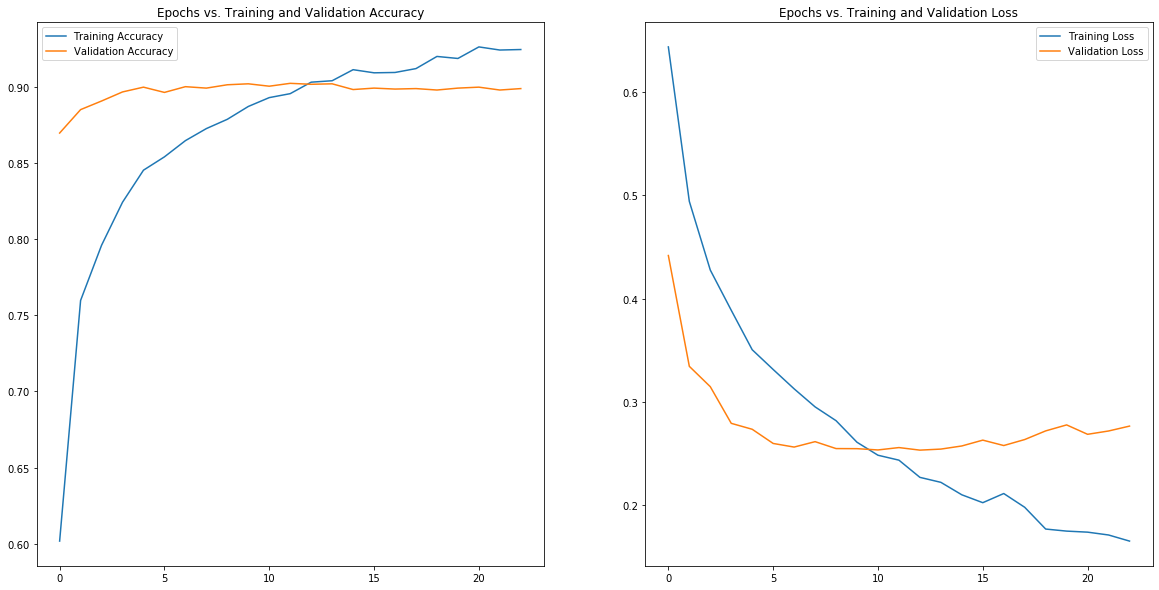

In [50]:
# Evaluate train and validation accuracies and losses
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Visualize epochs vs. train and validation accuracies and losses
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Epochs vs. Training and Validation Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Epochs vs. Training and Validation Loss')

plt.show()

In [51]:
final_model = keras.models.load_model('imdb_sentiment.h5')
metrics = np.zeros(4)
X_test_vec = tfidf.transform(X_test)
prediction = final_model.predict(X_test_vec)
y_pred = (prediction > 0.5)
metrics = get_metrics(y_test, y_pred, metrics)
metrics = metrics * 100
print('Average accuracy: {:.2f} % \n'
      'Average precision: {:.2f} % \n'
      'Average recall: {:.2f} % \n'
      'Average f-measure: {:.2f} % \n'
      .format(metrics[0], metrics[1],
              metrics[2], metrics[3]))

Average accuracy: 90.45 % 
Average precision: 90.45 % 
Average recall: 90.44 % 
Average f-measure: 90.44 % 



In [ ]:
for train, cv in kf.split(X, y):
    X_train, X_cv = X[train], X[cv]
    y_train, y_cv = y[train], y[cv]
    X_train_gen = [x for x in X_train]
    X_cv_gen = [x for x in X_cv]
    X_train = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=100)
    X_cv = keras.preprocessing.sequence.pad_sequences(X_cv, maxlen=100)
    history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=50, callbacks=[early_stopping],
                    validation_split=0.15)

## Deliverable for competition

In [53]:
df_test = pd.read_csv('test_without_labels.csv')

In [54]:
X_final = df_test['Content'].values

In [61]:
tfidf.fit(X)
X_train_vec = tfidf.transform(X)
input_shape = X_train_vec.shape[1:]

keras.backend.clear_session()

model = keras.Sequential([
    keras.layers.Dropout(0.25, input_shape=input_shape),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.9),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.85),
    keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                   "imdb_sentiment.h5", save_best_only=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.7, patience=3)
optimizer = keras.optimizers.Adam(lr=1e-2, amsgrad=True)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [62]:
model.fit(X_train_vec, y,
          batch_size=256, epochs=80, 
          callbacks=[early_stopping, 
                     model_checkpoint,
                     reduce_lr],
          validation_split=0.20)

Train on 21250 samples, validate on 3750 samples
Epoch 1/80
21250/21250 [==============================] - 24s 1ms/sample - loss: 0.6268 - accuracy: 0.6173 - val_loss: 0.4106 - val_accuracy: 0.8736
Epoch 2/80
21250/21250 [==============================] - 19s 879us/sample - loss: 0.4924 - accuracy: 0.7607 - val_loss: 0.3294 - val_accuracy: 0.8901
Epoch 3/80
21250/21250 [==============================] - 19s 884us/sample - loss: 0.4349 - accuracy: 0.8056 - val_loss: 0.3001 - val_accuracy: 0.8987
Epoch 4/80
21250/21250 [==============================] - 19s 872us/sample - loss: 0.3815 - accuracy: 0.8316 - val_loss: 0.2712 - val_accuracy: 0.9003
Epoch 5/80
21250/21250 [==============================] - 19s 875us/sample - loss: 0.3635 - accuracy: 0.8457 - val_loss: 0.2644 - val_accuracy: 0.9003
Epoch 6/80
21250/21250 [==============================] - 19s 874us/sample - loss: 0.3236 - accuracy: 0.8606 - val_loss: 0.2508 - val_accuracy: 0.9037
Epoch 7/80
21250/21250 [=======================

In [75]:
X_test_vec = tfidf.transform(X_final)
final_model = keras.models.load_model('imdb_sentiment.h5')
prediction = final_model.predict(X_test_vec)
y_pred = (prediction > 0.5)

In [76]:
y_pred = y_pred * 1

In [77]:
df_results = pd.DataFrame({'Id':df_test['Id'], 'Predicted':y_pred[:, 0]})

In [78]:
df_results.to_csv('sentiment_predictions.csv',index=False, header=True)